In [94]:
import numpy as np
import time
import torch
import random
import sys
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn, optim, autograd
from scipy.integrate import odeint

from google.colab import drive
drive.mount("/content/drive")

main_path = "/content/drive/My Drive/Workspace/Fourier_PINN/" # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)

from utils import draw_two_dimension, MultiSubplotDraw

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
class Parameters:
    alpha = 1.00
    beta = 3.00
    gamma = 0.30
    e = 0.333 * 0.30

class TrainArgs:
    iteration = 1000000
    epoch_step = 1000
    test_step = 10000
    initial_lr = 0.01
    main_path = "/content/drive/My Drive/Workspace/Fourier_PINN/"


class Config:
    def __init__(self):
        self.model_name = "PP_Fourier"
        self.curve_names = ["U", "V"]
        self.params = Parameters
        self.args = TrainArgs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = 0

        self.T = 12
        self.T_unit = 6e-4
        self.T_N = int(self.T / self.T_unit)

        self.prob_dim = 2
        self.y0 = np.asarray([10.0, 5.0])
        self.t = np.asarray([i * self.T_unit for i in range(self.T_N)])
        self.t_torch = torch.tensor(self.t, dtype=torch.float32).to(self.device)
        self.x = torch.tensor(np.asarray([[[i * self.T_unit] * self.prob_dim for i in range(self.T_N)]]), dtype=torch.float32).to(self.device)
        # print(self.x.shape)
        self.truth = odeint(self.pend, self.y0, self.t)

        self.modes = 64  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.width = 16
        self.fc_map_dim = 128
    
    def pend(self, y, t):
        dydt = np.asarray([
            (self.params.alpha * y[0]) - self.params.gamma * y[0] * y[1],
            - self.params.beta * y[1] + self.params.e * y[0] * y[1]
        ])
        return dydt


In [96]:
class SpectralConv1d(nn.Module):
    def __init__(self, config):
        super(SpectralConv1d, self).__init__()
        self.config = config
        self.in_channels = self.config.width
        self.out_channels = self.config.width
        self.scale = 1 / (self.in_channels * self.out_channels)
        self.weights = nn.Parameter(self.scale * torch.rand(self.in_channels, self.out_channels, self.config.modes, dtype=torch.cfloat))

    def compl_mul1d(self, input, weights):
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, dtype=torch.cfloat).to(self.config.device) 
        out_ft[:, :, :self.config.modes] = self.compl_mul1d(x_ft[:, :, :self.config.modes], self.weights)
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


class FourierModel(nn.Module):
    def __init__(self, config):
        super(FourierModel, self).__init__()
        self.time_string = time.strftime("%Y%m%d_%H%M%S", time.localtime(time.time()))
        self.config = config
        self.setup_seed(self.config.seed)
        
        self.fc0 = nn.Linear(self.config.prob_dim, self.config.width)  # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.config)
        self.conv1 = SpectralConv1d(self.config)
        self.conv2 = SpectralConv1d(self.config)
        self.conv3 = SpectralConv1d(self.config)
        self.w0 = nn.Conv1d(self.config.width, self.config.width, 1)
        self.w1 = nn.Conv1d(self.config.width, self.config.width, 1)
        self.w2 = nn.Conv1d(self.config.width, self.config.width, 1)
        self.w3 = nn.Conv1d(self.config.width, self.config.width, 1)

        self.fc1 = nn.Linear(self.config.width, self.config.fc_map_dim)
        self.fc2 = nn.Linear(self.config.fc_map_dim, self.config.prob_dim)

        self.criterion = torch.nn.MSELoss("sum").to(self.config.device)

        self.y_tmp = None
        self.epoch_tmp = None
        self.loss_record_tmp = None

        self.figure_save_path_folder = "{0}/figure/{1}_{2}/".format(self.config.args.main_path, self.config.model_name, self.time_string)
        if not os.path.exists(self.figure_save_path_folder):
            os.makedirs(self.figure_save_path_folder)
        self.default_colors = ["red", "blue", "green", "orange", "cyan", "purple", "pink", "indigo", "brown", "grey"]

        print("using {}".format(str(self.config.device)))
        print("iteration = {}".format(self.config.args.iteration))
        print("epoch_step = {}".format(self.config.args.epoch_step))
        print("test_step = {}".format(self.config.args.test_step))
        print("model_name = {}".format(self.config.model_name))
        print("time_string = {}".format(self.time_string))


    def forward(self, x):
        # print("cp1", x.shape)
        x = self.fc0(x)
        # print("cp2", x.shape)
        x = x.permute(0, 2, 1)
        # print("cp3", x.shape)

        x1 = self.conv0(x)
        # print("cp4", x1.shape)
        x2 = self.w0(x)
        # print("cp5", x2.shape)
        x = x1 + x2
        x = F.gelu(x)
        # print("cp6", x.shape)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        # print("cp7", x.shape)
        x = x.permute(0, 2, 1)
        # print("cp8", x.shape)
        x = self.fc1(x)
        # print("cp9", x.shape)
        x = F.gelu(x)
        # print("cp10", x.shape)

        x = self.fc2(x)
        # print("cp11", x.shape)

        # print(x.shape)
        return x

    
    @staticmethod
    def setup_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
    
    def ode_gradient(self, x, y):
        u = y[0, :, 0]
        v = y[0, :, 1]
        u_t = torch.gradient(u, spacing=(self.config.t_torch,))[0]
        v_t = torch.gradient(v, spacing=(self.config.t_torch,))[0]
        return u_t - (self.config.params.alpha - self.config.params.gamma * v) * u, v_t - (self.config.params.e * u - self.config.params.beta) * v

    def loss(self, y):
        y0_pred = y[0, 0, :]
        y0_true = torch.tensor(self.config.y0, dtype=torch.float32).to(self.config.device)

        ode_1, ode_2 = self.ode_gradient(self.config.x, y)
        zeros_1D = torch.tensor([0.0] * self.config.T_N).to(self.config.device)

        loss1 = self.criterion(y0_pred, y0_true)
        loss2 = 10 * (self.criterion(ode_1, zeros_1D) + self.criterion(ode_2, zeros_1D))
        loss3 = self.criterion(torch.abs(y[:, :, 0] - 9), y[:, :, 0] - 9) + self.criterion(torch.abs(y[:, :, 1]), y[:, :, 1])
        # loss4 = self.criterion(1 / u_0, pt_all_zeros_3)
        # loss5 = self.criterion(torch.abs(u_0 - v_0), u_0 - v_0)

        loss = loss1 + loss2 + loss3
        loss_list = [loss1, loss2, loss3]
        return loss, loss_list
    

    def train_model(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.args.initial_lr, weight_decay=0)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: 1 / (e / 10000 + 1))
        self.train()

        start_time = time.time()
        start_time_0 = start_time
        loss_record = []
        
        for epoch in range(1, self.config.args.iteration + 1):
            optimizer.zero_grad()

            y = self.forward(self.config.x)
            loss, loss_list = self.loss(y)
            loss_record.append(loss.item())

            loss.backward()
            optimizer.step()
            scheduler.step()

            if epoch % self.config.args.epoch_step == 0:
                now_time = time.time()
                loss_print_part = " ".join(["Loss_{0:d}:{1:.6f}".format(i + 1, loss_part.item()) for i, loss_part in enumerate(loss_list)])
                print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} {3} Lr:{4:.6f} Time:{5:.6f}s ({6:.2f}min in total, {7:.2f}min remains)".format(epoch, self.config.args.iteration, loss.item(), loss_print_part, optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0, (now_time - start_time_0) / 60.0 / epoch * (self.config.args.iteration - epoch)))
                start_time = now_time

                if epoch % self.config.args.test_step == 0:
                    self.y_tmp = y
                    self.epoch_tmp = epoch
                    self.loss_record_tmp = loss_record
                    self.test_model()
    
    def test_model(self):
        y_draw = self.y_tmp[0].cpu().detach().numpy().swapaxes(0, 1)
        x_draw = self.config.t
        y_draw_truth = self.config.truth.swapaxes(0, 1)
        save_path = "{}/{}_{}_epoch={}.png".format(self.figure_save_path_folder, self.config.model_name, self.time_string, self.epoch_tmp)
        draw_two_dimension(
            y_lists=np.concatenate([y_draw, y_draw_truth], axis=0),
            x_list=x_draw,
            color_list=self.default_colors[: 2 * self.config.prob_dim],
            legend_list=self.config.curve_names + ["{}_true".format(item) for item in self.config.curve_names],
            line_style_list=["solid"] * self.config.prob_dim + ["dashed"] * self.config.prob_dim,
            fig_title="{}_{}_epoch={}".format(self.config.model_name, self.time_string, self.epoch_tmp),
            fig_size=(8, 6),
            show_flag=True,
            save_flag=True,
            save_path=save_path,
            save_dpi=300
        )
        print("Figure is saved to {}".format(save_path))
        self.draw_loss_multi(self.loss_record_tmp, [1.0, 0.5, 0.25])
    
    @staticmethod
    def draw_loss_multi(loss_list, last_rate_list):
        m = MultiSubplotDraw(row=1, col=len(last_rate_list), fig_size=(8 * len(last_rate_list), 6), tight_layout_flag=True, show_flag=True, save_flag=False, save_path=None)
        for one_rate in last_rate_list:
            m.add_subplot(
                y_lists=[loss_list[-int(len(loss_list) * one_rate):]],
                x_list=range(len(loss_list) - int(len(loss_list) * one_rate) + 1, len(loss_list) + 1),
                color_list=["blue"],
                line_style_list=["solid"],
                fig_title="Loss - lastest ${}$% - epoch ${}$ to ${}$".format(int(100 * one_rate), len(loss_list) - int(len(loss_list) * one_rate) + 1, len(loss_list)),
                fig_x_label="epoch",
                fig_y_label="loss",
            )
        m.draw()




 


using cuda
iteration = 1000000
epoch_step = 1000
test_step = 10000
model_name = PP_Fourier
time_string = 20221014_061607
Epoch [01000/1000000] Loss:2.303328 Loss_1:0.018371 Loss_2:2.284956 Loss_3:0.000000 Lr:0.009091 Time:13.003078s (0.22min in total, 216.50min remains)
Epoch [02000/1000000] Loss:0.921791 Loss_1:0.005591 Loss_2:0.916201 Loss_3:0.000000 Lr:0.008333 Time:12.901685s (0.43min in total, 215.44min remains)
Epoch [03000/1000000] Loss:0.641854 Loss_1:0.002829 Loss_2:0.639025 Loss_3:0.000000 Lr:0.007692 Time:12.833497s (0.65min in total, 214.57min remains)
Epoch [04000/1000000] Loss:0.457235 Loss_1:0.001801 Loss_2:0.455433 Loss_3:0.000000 Lr:0.007143 Time:12.908807s (0.86min in total, 214.34min remains)
Epoch [05000/1000000] Loss:0.787446 Loss_1:0.002350 Loss_2:0.785095 Loss_3:0.000000 Lr:0.006667 Time:13.756007s (1.09min in total, 216.92min remains)
Epoch [06000/1000000] Loss:0.229438 Loss_1:0.001527 Loss_2:0.227911 Loss_3:0.000000 Lr:0.006250 Time:12.953828s (1.31min in total

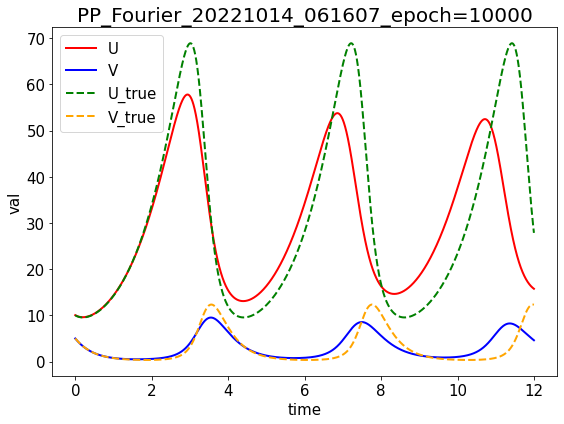

Figure is saved to /content/drive/My Drive/Workspace/Fourier_PINN//figure/PP_Fourier_20221014_061607//PP_Fourier_20221014_061607_epoch=10000.png


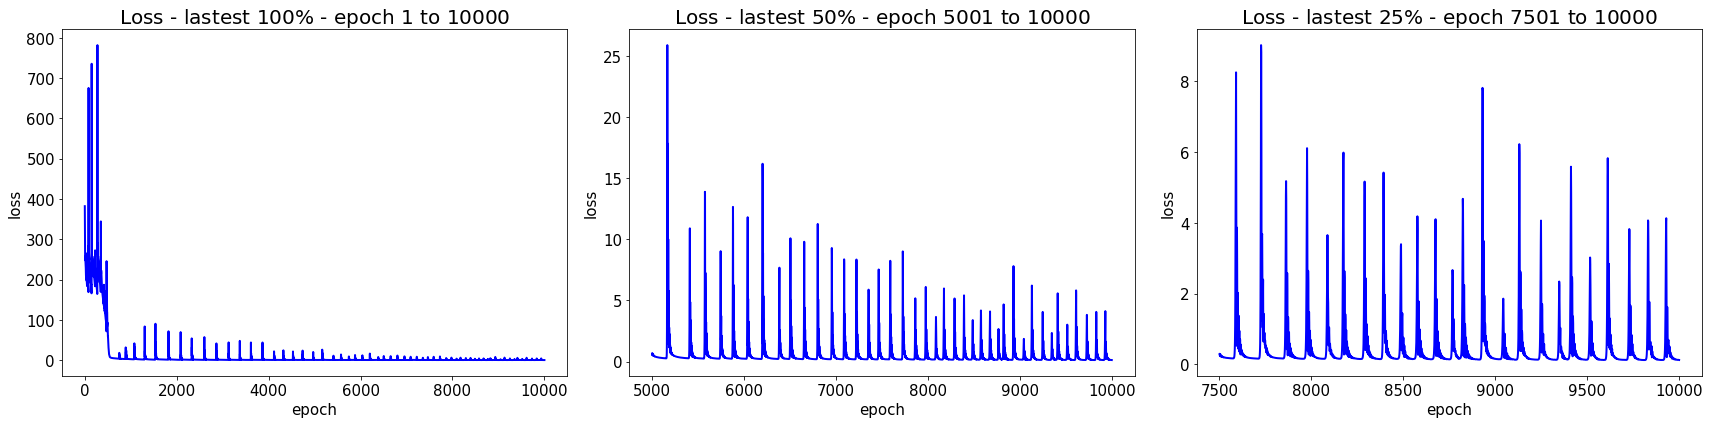

Epoch [11000/1000000] Loss:0.150891 Loss_1:0.000624 Loss_2:0.150267 Loss_3:0.000000 Lr:0.004762 Time:14.339841s (2.41min in total, 216.58min remains)
Epoch [12000/1000000] Loss:0.221108 Loss_1:0.001300 Loss_2:0.219808 Loss_3:0.000000 Lr:0.004545 Time:12.986134s (2.63min in total, 216.15min remains)
Epoch [13000/1000000] Loss:0.117857 Loss_1:0.000514 Loss_2:0.117344 Loss_3:0.000000 Lr:0.004348 Time:13.134093s (2.84min in total, 215.94min remains)
Epoch [14000/1000000] Loss:0.099103 Loss_1:0.000513 Loss_2:0.098589 Loss_3:0.000000 Lr:0.004167 Time:13.144940s (3.06min in total, 215.74min remains)
Epoch [15000/1000000] Loss:0.105115 Loss_1:0.000271 Loss_2:0.104844 Loss_3:0.000000 Lr:0.004000 Time:13.088290s (3.28min in total, 215.48min remains)
Epoch [16000/1000000] Loss:0.287900 Loss_1:0.002229 Loss_2:0.285671 Loss_3:0.000000 Lr:0.003846 Time:13.071596s (3.50min in total, 215.21min remains)
Epoch [17000/1000000] Loss:0.070817 Loss_1:0.000600 Loss_2:0.070217 Loss_3:0.000000 Lr:0.003704 Time

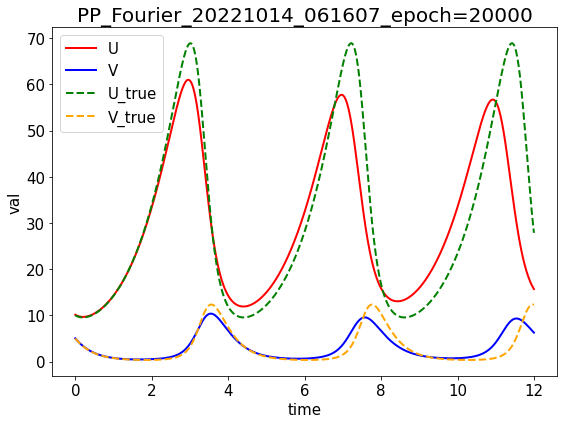

Figure is saved to /content/drive/My Drive/Workspace/Fourier_PINN//figure/PP_Fourier_20221014_061607//PP_Fourier_20221014_061607_epoch=20000.png


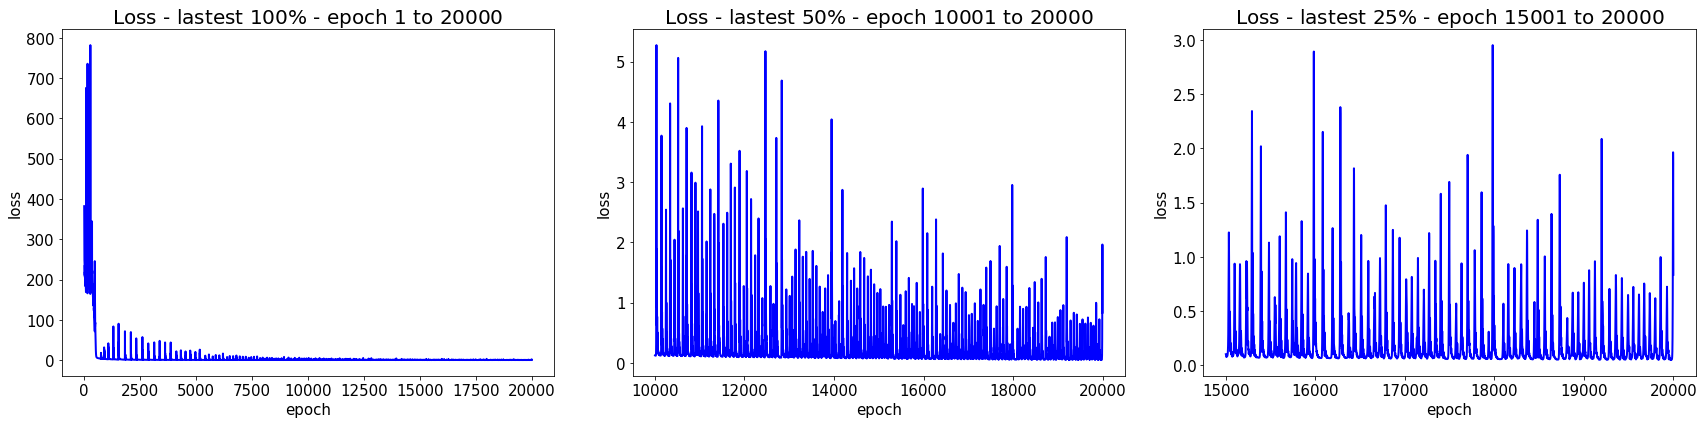

Epoch [21000/1000000] Loss:0.115050 Loss_1:0.000708 Loss_2:0.114342 Loss_3:0.000000 Lr:0.003226 Time:14.740993s (4.63min in total, 216.05min remains)


In [ ]:
config = Config()
model = FourierModel(config).to(config.device)
model.train_model()

torch.Size([1, 20000, 2])
Epoch [01000/1000000] Loss:2.303328 Loss_1:0.018371 Loss_2:2.284956 Loss_3:0.000000 Lr:0.009091 Time:13.328176s (0.22min in total, 221.91min remains)
Epoch [02000/1000000] Loss:0.921791 Loss_1:0.005591 Loss_2:0.916201 Loss_3:0.000000 Lr:0.008333 Time:13.196895s (0.44min in total, 220.60min remains)
Epoch [03000/1000000] Loss:0.641854 Loss_1:0.002829 Loss_2:0.639025 Loss_3:0.000000 Lr:0.007692 Time:13.312016s (0.66min in total, 220.65min remains)
Epoch [04000/1000000] Loss:0.457235 Loss_1:0.001801 Loss_2:0.455433 Loss_3:0.000000 Lr:0.007143 Time:13.013753s (0.88min in total, 219.33min remains)
Epoch [05000/1000000] Loss:0.787446 Loss_1:0.002350 Loss_2:0.785095 Loss_3:0.000000 Lr:0.006667 Time:12.810691s (1.09min in total, 217.78min remains)
Epoch [06000/1000000] Loss:0.229438 Loss_1:0.001527 Loss_2:0.227911 Loss_3:0.000000 Lr:0.006250 Time:12.940542s (1.31min in total, 217.03min remains)
Epoch [07000/1000000] Loss:0.267195 Loss_1:0.002526 Loss_2:0.264669 Loss_3

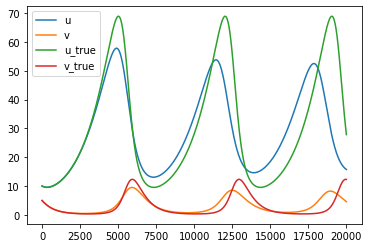

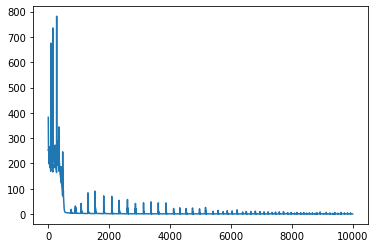

Epoch [11000/1000000] Loss:0.150891 Loss_1:0.000624 Loss_2:0.150267 Loss_3:0.000000 Lr:0.004762 Time:13.293458s (2.40min in total, 216.07min remains)
Epoch [12000/1000000] Loss:0.221108 Loss_1:0.001300 Loss_2:0.219808 Loss_3:0.000000 Lr:0.004545 Time:12.945638s (2.62min in total, 215.63min remains)
Epoch [13000/1000000] Loss:0.117857 Loss_1:0.000514 Loss_2:0.117344 Loss_3:0.000000 Lr:0.004348 Time:12.877291s (2.83min in total, 215.13min remains)
Epoch [14000/1000000] Loss:0.099103 Loss_1:0.000513 Loss_2:0.098589 Loss_3:0.000000 Lr:0.004167 Time:12.815801s (3.05min in total, 214.61min remains)
Epoch [15000/1000000] Loss:0.105115 Loss_1:0.000271 Loss_2:0.104844 Loss_3:0.000000 Lr:0.004000 Time:12.936363s (3.26min in total, 214.25min remains)
Epoch [16000/1000000] Loss:0.287900 Loss_1:0.002229 Loss_2:0.285671 Loss_3:0.000000 Lr:0.003846 Time:12.908177s (3.48min in total, 213.89min remains)
Epoch [17000/1000000] Loss:0.070817 Loss_1:0.000600 Loss_2:0.070217 Loss_3:0.000000 Lr:0.003704 Time

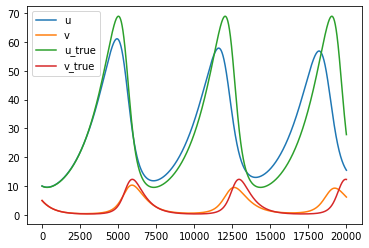

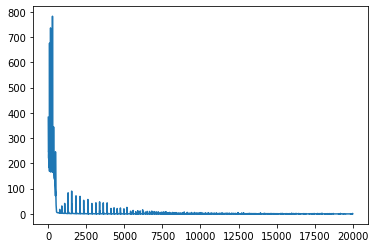

Epoch [21000/1000000] Loss:0.115050 Loss_1:0.000708 Loss_2:0.114342 Loss_3:0.000000 Lr:0.003226 Time:13.308862s (4.56min in total, 212.56min remains)
Epoch [22000/1000000] Loss:0.044643 Loss_1:0.000501 Loss_2:0.044142 Loss_3:0.000000 Lr:0.003125 Time:13.397465s (4.78min in total, 212.61min remains)
Epoch [23000/1000000] Loss:0.039877 Loss_1:0.000278 Loss_2:0.039599 Loss_3:0.000000 Lr:0.003030 Time:12.833321s (5.00min in total, 212.25min remains)
Epoch [24000/1000000] Loss:0.051669 Loss_1:0.000411 Loss_2:0.051258 Loss_3:0.000000 Lr:0.002941 Time:12.962585s (5.21min in total, 211.98min remains)
Epoch [25000/1000000] Loss:0.065285 Loss_1:0.000417 Loss_2:0.064868 Loss_3:0.000000 Lr:0.002857 Time:13.001320s (5.43min in total, 211.74min remains)
Epoch [26000/1000000] Loss:0.118459 Loss_1:0.000339 Loss_2:0.118120 Loss_3:0.000000 Lr:0.002778 Time:12.854125s (5.64min in total, 211.42min remains)
Epoch [27000/1000000] Loss:0.034570 Loss_1:0.000228 Loss_2:0.034342 Loss_3:0.000000 Lr:0.002703 Time

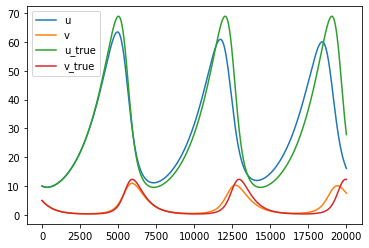

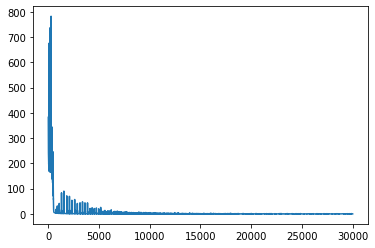

Epoch [31000/1000000] Loss:0.030758 Loss_1:0.000169 Loss_2:0.030589 Loss_3:0.000000 Lr:0.002439 Time:13.191643s (6.72min in total, 210.19min remains)
Epoch [32000/1000000] Loss:0.031618 Loss_1:0.000113 Loss_2:0.031505 Loss_3:0.000000 Lr:0.002381 Time:12.873653s (6.94min in total, 209.90min remains)
Epoch [33000/1000000] Loss:0.026339 Loss_1:0.000238 Loss_2:0.026101 Loss_3:0.000000 Lr:0.002326 Time:12.828510s (7.15min in total, 209.60min remains)
Epoch [34000/1000000] Loss:0.149676 Loss_1:0.000268 Loss_2:0.149407 Loss_3:0.000000 Lr:0.002273 Time:13.443225s (7.38min in total, 209.59min remains)
Epoch [35000/1000000] Loss:0.023634 Loss_1:0.000132 Loss_2:0.023502 Loss_3:0.000000 Lr:0.002222 Time:12.988732s (7.59min in total, 209.36min remains)
Epoch [36000/1000000] Loss:0.018016 Loss_1:0.000188 Loss_2:0.017828 Loss_3:0.000000 Lr:0.002174 Time:12.889213s (7.81min in total, 209.08min remains)
Epoch [37000/1000000] Loss:0.017697 Loss_1:0.000168 Loss_2:0.017529 Loss_3:0.000000 Lr:0.002128 Time

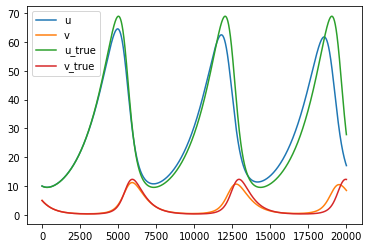

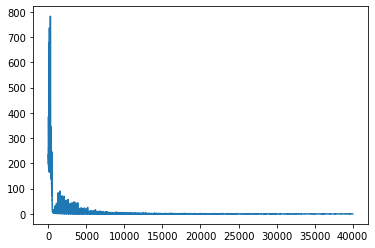

Epoch [41000/1000000] Loss:0.052599 Loss_1:0.000700 Loss_2:0.051899 Loss_3:0.000000 Lr:0.001961 Time:13.266137s (8.89min in total, 207.91min remains)
Epoch [42000/1000000] Loss:0.028882 Loss_1:0.000461 Loss_2:0.028421 Loss_3:0.000000 Lr:0.001923 Time:12.789716s (9.10min in total, 207.61min remains)
Epoch [43000/1000000] Loss:0.017896 Loss_1:0.000124 Loss_2:0.017772 Loss_3:0.000000 Lr:0.001887 Time:12.829773s (9.32min in total, 207.33min remains)
Epoch [44000/1000000] Loss:0.029040 Loss_1:0.000159 Loss_2:0.028881 Loss_3:0.000000 Lr:0.001852 Time:12.902714s (9.53min in total, 207.07min remains)
Epoch [45000/1000000] Loss:0.013720 Loss_1:0.000100 Loss_2:0.013620 Loss_3:0.000000 Lr:0.001818 Time:13.258400s (9.75min in total, 206.95min remains)
Epoch [46000/1000000] Loss:0.011104 Loss_1:0.000095 Loss_2:0.011009 Loss_3:0.000000 Lr:0.001786 Time:13.283133s (9.97min in total, 206.83min remains)
Epoch [47000/1000000] Loss:0.012195 Loss_1:0.000066 Loss_2:0.012128 Loss_3:0.000000 Lr:0.001754 Time

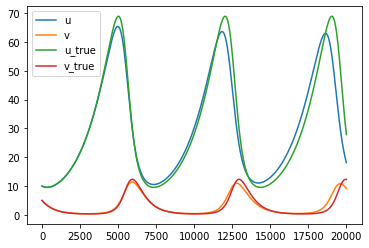

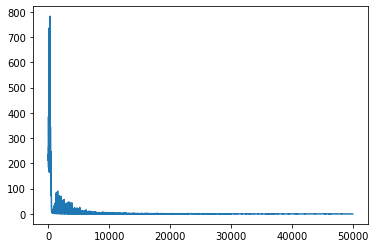

Epoch [51000/1000000] Loss:0.024810 Loss_1:0.000063 Loss_2:0.024747 Loss_3:0.000000 Lr:0.001639 Time:13.233184s (11.08min in total, 206.17min remains)
Epoch [52000/1000000] Loss:0.036386 Loss_1:0.000035 Loss_2:0.036350 Loss_3:0.000000 Lr:0.001613 Time:12.832994s (11.29min in total, 205.89min remains)
Epoch [53000/1000000] Loss:0.047333 Loss_1:0.000185 Loss_2:0.047148 Loss_3:0.000000 Lr:0.001587 Time:12.982547s (11.51min in total, 205.66min remains)
Epoch [54000/1000000] Loss:0.011364 Loss_1:0.000051 Loss_2:0.011313 Loss_3:0.000000 Lr:0.001563 Time:12.820686s (11.72min in total, 205.38min remains)
Epoch [55000/1000000] Loss:0.015426 Loss_1:0.000134 Loss_2:0.015292 Loss_3:0.000000 Lr:0.001538 Time:12.846441s (11.94min in total, 205.12min remains)
Epoch [56000/1000000] Loss:0.012036 Loss_1:0.000163 Loss_2:0.011872 Loss_3:0.000000 Lr:0.001515 Time:12.817275s (12.15min in total, 204.84min remains)
Epoch [57000/1000000] Loss:0.007943 Loss_1:0.000098 Loss_2:0.007844 Loss_3:0.000000 Lr:0.00149

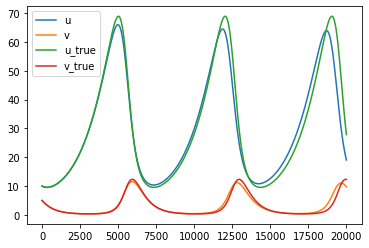

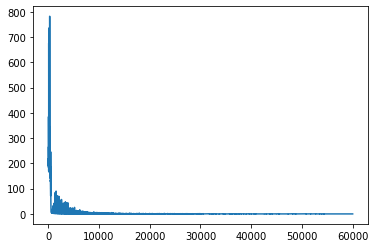

Epoch [61000/1000000] Loss:0.157873 Loss_1:0.001572 Loss_2:0.156302 Loss_3:0.000000 Lr:0.001408 Time:13.135537s (13.24min in total, 203.76min remains)
Epoch [62000/1000000] Loss:0.007034 Loss_1:0.000047 Loss_2:0.006988 Loss_3:0.000000 Lr:0.001389 Time:12.865131s (13.45min in total, 203.51min remains)
Epoch [63000/1000000] Loss:0.092184 Loss_1:0.000360 Loss_2:0.091824 Loss_3:0.000000 Lr:0.001370 Time:12.873079s (13.67min in total, 203.25min remains)
Epoch [64000/1000000] Loss:0.102080 Loss_1:0.000367 Loss_2:0.101713 Loss_3:0.000000 Lr:0.001351 Time:12.890969s (13.88min in total, 203.01min remains)
Epoch [65000/1000000] Loss:0.019257 Loss_1:0.000049 Loss_2:0.019207 Loss_3:0.000000 Lr:0.001333 Time:12.904121s (14.10min in total, 202.76min remains)
Epoch [66000/1000000] Loss:0.008163 Loss_1:0.000048 Loss_2:0.008115 Loss_3:0.000000 Lr:0.001316 Time:12.809355s (14.31min in total, 202.50min remains)
Epoch [67000/1000000] Loss:0.010753 Loss_1:0.000051 Loss_2:0.010702 Loss_3:0.000000 Lr:0.00129

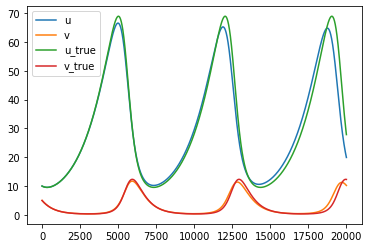

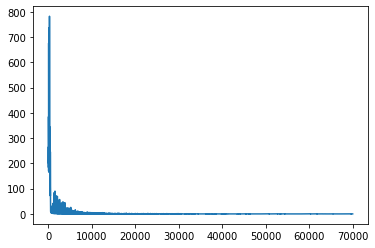

Epoch [71000/1000000] Loss:0.007003 Loss_1:0.000086 Loss_2:0.006916 Loss_3:0.000000 Lr:0.001235 Time:13.233491s (15.39min in total, 201.33min remains)
Epoch [72000/1000000] Loss:0.004591 Loss_1:0.000034 Loss_2:0.004557 Loss_3:0.000000 Lr:0.001220 Time:13.562453s (15.61min in total, 201.23min remains)
Epoch [73000/1000000] Loss:0.145687 Loss_1:0.000087 Loss_2:0.145599 Loss_3:0.000000 Lr:0.001205 Time:12.793010s (15.83min in total, 200.97min remains)
Epoch [74000/1000000] Loss:0.077539 Loss_1:0.000045 Loss_2:0.077494 Loss_3:0.000000 Lr:0.001190 Time:12.830608s (16.04min in total, 200.71min remains)
Epoch [75000/1000000] Loss:0.004191 Loss_1:0.000036 Loss_2:0.004155 Loss_3:0.000000 Lr:0.001176 Time:12.758762s (16.25min in total, 200.45min remains)
Epoch [76000/1000000] Loss:0.012366 Loss_1:0.000153 Loss_2:0.012214 Loss_3:0.000000 Lr:0.001163 Time:12.911073s (16.47min in total, 200.21min remains)
Epoch [77000/1000000] Loss:0.022239 Loss_1:0.000083 Loss_2:0.022156 Loss_3:0.000000 Lr:0.00114

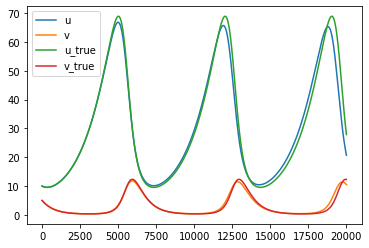

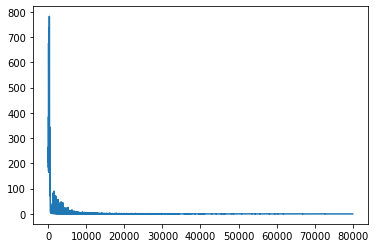

Epoch [81000/1000000] Loss:0.003636 Loss_1:0.000026 Loss_2:0.003610 Loss_3:0.000000 Lr:0.001099 Time:13.239903s (17.55min in total, 199.09min remains)
Epoch [82000/1000000] Loss:0.003421 Loss_1:0.000026 Loss_2:0.003395 Loss_3:0.000000 Lr:0.001087 Time:12.870364s (17.76min in total, 198.85min remains)
Epoch [83000/1000000] Loss:0.009671 Loss_1:0.000070 Loss_2:0.009600 Loss_3:0.000000 Lr:0.001075 Time:12.937219s (17.98min in total, 198.63min remains)
Epoch [84000/1000000] Loss:0.152358 Loss_1:0.000050 Loss_2:0.152308 Loss_3:0.000000 Lr:0.001064 Time:13.410632s (18.20min in total, 198.48min remains)
Epoch [85000/1000000] Loss:0.005036 Loss_1:0.000019 Loss_2:0.005016 Loss_3:0.000000 Lr:0.001053 Time:12.862252s (18.42min in total, 198.24min remains)
Epoch [86000/1000000] Loss:0.011928 Loss_1:0.000080 Loss_2:0.011849 Loss_3:0.000000 Lr:0.001042 Time:12.944342s (18.63min in total, 198.02min remains)
Epoch [87000/1000000] Loss:0.018380 Loss_1:0.000062 Loss_2:0.018318 Loss_3:0.000000 Lr:0.00103

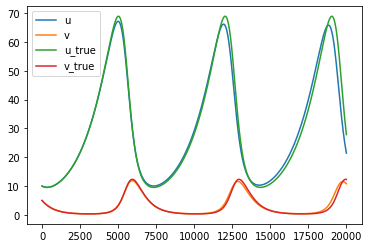

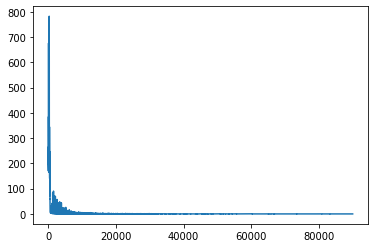

Epoch [91000/1000000] Loss:0.006049 Loss_1:0.000010 Loss_2:0.006040 Loss_3:0.000000 Lr:0.000990 Time:13.229770s (19.71min in total, 196.91min remains)
Epoch [92000/1000000] Loss:0.005120 Loss_1:0.000052 Loss_2:0.005069 Loss_3:0.000000 Lr:0.000980 Time:12.831441s (19.93min in total, 196.66min remains)
Epoch [93000/1000000] Loss:0.005563 Loss_1:0.000116 Loss_2:0.005447 Loss_3:0.000000 Lr:0.000971 Time:12.874005s (20.14min in total, 196.43min remains)
Epoch [94000/1000000] Loss:0.006916 Loss_1:0.000031 Loss_2:0.006885 Loss_3:0.000000 Lr:0.000962 Time:12.793194s (20.35min in total, 196.18min remains)
Epoch [95000/1000000] Loss:0.002769 Loss_1:0.000016 Loss_2:0.002753 Loss_3:0.000000 Lr:0.000952 Time:12.993620s (20.57min in total, 195.96min remains)
Epoch [96000/1000000] Loss:0.144402 Loss_1:0.000243 Loss_2:0.144159 Loss_3:0.000000 Lr:0.000943 Time:12.987087s (20.79min in total, 195.74min remains)
Epoch [97000/1000000] Loss:0.014646 Loss_1:0.000003 Loss_2:0.014643 Loss_3:0.000000 Lr:0.00093

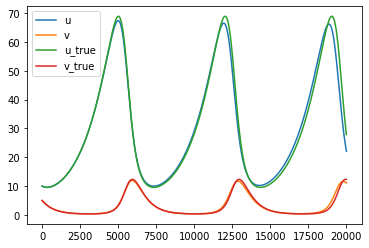

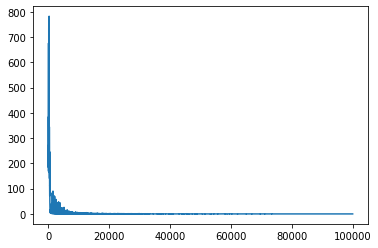

Epoch [101000/1000000] Loss:0.026358 Loss_1:0.000028 Loss_2:0.026331 Loss_3:0.000000 Lr:0.000901 Time:13.179395s (21.87min in total, 194.68min remains)
Epoch [102000/1000000] Loss:0.003347 Loss_1:0.000015 Loss_2:0.003332 Loss_3:0.000000 Lr:0.000893 Time:12.939713s (22.09min in total, 194.45min remains)
Epoch [103000/1000000] Loss:0.005515 Loss_1:0.000017 Loss_2:0.005498 Loss_3:0.000000 Lr:0.000885 Time:12.885566s (22.30min in total, 194.22min remains)
Epoch [104000/1000000] Loss:0.007640 Loss_1:0.000010 Loss_2:0.007630 Loss_3:0.000000 Lr:0.000877 Time:12.848536s (22.52min in total, 193.99min remains)
Epoch [105000/1000000] Loss:0.147726 Loss_1:0.000083 Loss_2:0.147643 Loss_3:0.000000 Lr:0.000870 Time:12.836947s (22.73min in total, 193.75min remains)
Epoch [106000/1000000] Loss:0.002381 Loss_1:0.000011 Loss_2:0.002370 Loss_3:0.000000 Lr:0.000862 Time:12.804718s (22.94min in total, 193.50min remains)
Epoch [107000/1000000] Loss:0.002224 Loss_1:0.000012 Loss_2:0.002213 Loss_3:0.000000 Lr:

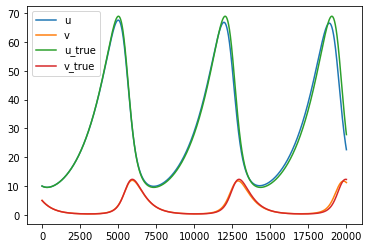

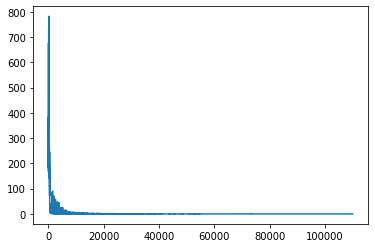

Epoch [111000/1000000] Loss:0.009885 Loss_1:0.000036 Loss_2:0.009850 Loss_3:0.000000 Lr:0.000826 Time:13.195735s (24.03min in total, 192.49min remains)
Epoch [112000/1000000] Loss:0.010862 Loss_1:0.000010 Loss_2:0.010852 Loss_3:0.000000 Lr:0.000820 Time:12.870347s (24.25min in total, 192.26min remains)
Epoch [113000/1000000] Loss:0.012719 Loss_1:0.000077 Loss_2:0.012641 Loss_3:0.000000 Lr:0.000813 Time:12.906508s (24.46min in total, 192.03min remains)
Epoch [114000/1000000] Loss:0.002205 Loss_1:0.000010 Loss_2:0.002195 Loss_3:0.000000 Lr:0.000806 Time:12.926692s (24.68min in total, 191.81min remains)
Epoch [115000/1000000] Loss:0.002386 Loss_1:0.000007 Loss_2:0.002379 Loss_3:0.000000 Lr:0.000800 Time:12.921388s (24.89min in total, 191.58min remains)
Epoch [116000/1000000] Loss:0.002002 Loss_1:0.000009 Loss_2:0.001993 Loss_3:0.000000 Lr:0.000794 Time:12.857041s (25.11min in total, 191.35min remains)
Epoch [117000/1000000] Loss:0.002156 Loss_1:0.000011 Loss_2:0.002145 Loss_3:0.000000 Lr:

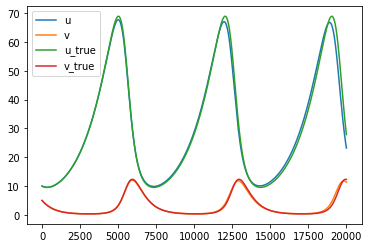

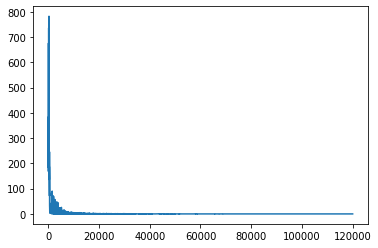

Epoch [121000/1000000] Loss:0.002177 Loss_1:0.000009 Loss_2:0.002168 Loss_3:0.000000 Lr:0.000763 Time:13.453002s (26.20min in total, 190.30min remains)
Epoch [122000/1000000] Loss:0.002015 Loss_1:0.000007 Loss_2:0.002008 Loss_3:0.000000 Lr:0.000758 Time:13.841442s (26.43min in total, 190.18min remains)
Epoch [123000/1000000] Loss:0.023335 Loss_1:0.000019 Loss_2:0.023316 Loss_3:0.000000 Lr:0.000752 Time:13.140599s (26.65min in total, 189.99min remains)
Epoch [124000/1000000] Loss:0.004246 Loss_1:0.000018 Loss_2:0.004228 Loss_3:0.000000 Lr:0.000746 Time:13.054479s (26.86min in total, 189.78min remains)
Epoch [125000/1000000] Loss:0.011669 Loss_1:0.000015 Loss_2:0.011654 Loss_3:0.000000 Lr:0.000741 Time:12.902595s (27.08min in total, 189.55min remains)
Epoch [126000/1000000] Loss:0.003969 Loss_1:0.000015 Loss_2:0.003954 Loss_3:0.000000 Lr:0.000735 Time:12.993649s (27.29min in total, 189.33min remains)
Epoch [127000/1000000] Loss:0.013912 Loss_1:0.000090 Loss_2:0.013822 Loss_3:0.000000 Lr:

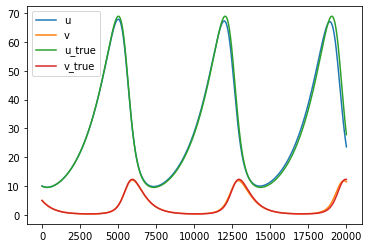

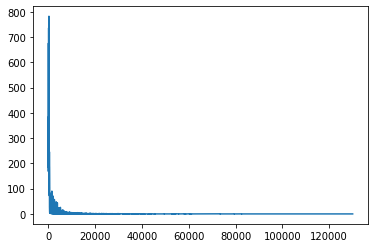

Epoch [131000/1000000] Loss:0.001721 Loss_1:0.000005 Loss_2:0.001716 Loss_3:0.000000 Lr:0.000709 Time:13.206725s (28.38min in total, 188.25min remains)
Epoch [132000/1000000] Loss:0.001789 Loss_1:0.000011 Loss_2:0.001778 Loss_3:0.000000 Lr:0.000704 Time:12.917690s (28.59min in total, 188.03min remains)
Epoch [133000/1000000] Loss:0.003008 Loss_1:0.000007 Loss_2:0.003001 Loss_3:0.000000 Lr:0.000699 Time:12.894511s (28.81min in total, 187.80min remains)
Epoch [134000/1000000] Loss:0.002401 Loss_1:0.000050 Loss_2:0.002351 Loss_3:0.000000 Lr:0.000694 Time:13.366068s (29.03min in total, 187.62min remains)
Epoch [135000/1000000] Loss:0.009535 Loss_1:0.000010 Loss_2:0.009525 Loss_3:0.000000 Lr:0.000690 Time:12.870733s (29.25min in total, 187.39min remains)
Epoch [136000/1000000] Loss:0.002986 Loss_1:0.000011 Loss_2:0.002975 Loss_3:0.000000 Lr:0.000685 Time:12.934944s (29.46min in total, 187.17min remains)
Epoch [137000/1000000] Loss:0.001828 Loss_1:0.000005 Loss_2:0.001823 Loss_3:0.000000 Lr:

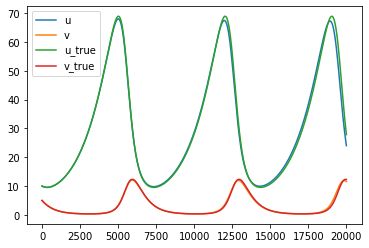

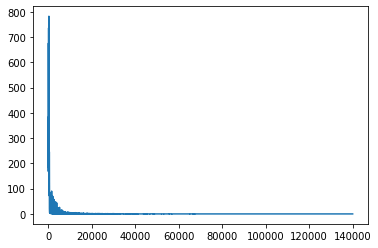

Epoch [141000/1000000] Loss:0.036897 Loss_1:0.000053 Loss_2:0.036844 Loss_3:0.000000 Lr:0.000662 Time:13.350884s (30.55min in total, 186.09min remains)
Epoch [142000/1000000] Loss:0.008633 Loss_1:0.000029 Loss_2:0.008604 Loss_3:0.000000 Lr:0.000658 Time:12.894415s (30.76min in total, 185.86min remains)
Epoch [143000/1000000] Loss:0.009467 Loss_1:0.000023 Loss_2:0.009444 Loss_3:0.000000 Lr:0.000654 Time:12.911206s (30.98min in total, 185.64min remains)
Epoch [144000/1000000] Loss:0.046698 Loss_1:0.000015 Loss_2:0.046683 Loss_3:0.000000 Lr:0.000649 Time:12.991769s (31.19min in total, 185.42min remains)
Epoch [145000/1000000] Loss:0.010315 Loss_1:0.000043 Loss_2:0.010272 Loss_3:0.000000 Lr:0.000645 Time:12.918957s (31.41min in total, 185.19min remains)
Epoch [146000/1000000] Loss:0.013034 Loss_1:0.000038 Loss_2:0.012997 Loss_3:0.000000 Lr:0.000641 Time:13.564073s (31.63min in total, 185.03min remains)
Epoch [147000/1000000] Loss:0.003880 Loss_1:0.000010 Loss_2:0.003870 Loss_3:0.000000 Lr:

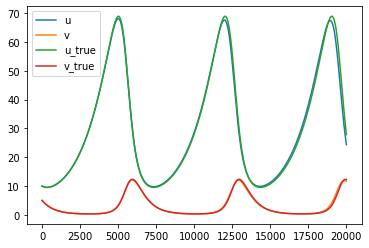

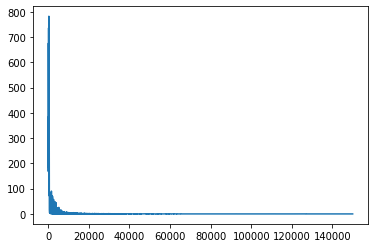

Epoch [151000/1000000] Loss:0.013179 Loss_1:0.000062 Loss_2:0.013116 Loss_3:0.000000 Lr:0.000621 Time:13.305855s (32.72min in total, 183.94min remains)
Epoch [152000/1000000] Loss:0.020763 Loss_1:0.000049 Loss_2:0.020714 Loss_3:0.000000 Lr:0.000617 Time:13.012450s (32.93min in total, 183.73min remains)
Epoch [153000/1000000] Loss:0.014786 Loss_1:0.000031 Loss_2:0.014755 Loss_3:0.000000 Lr:0.000613 Time:12.785417s (33.15min in total, 183.49min remains)
Epoch [154000/1000000] Loss:0.005967 Loss_1:0.000025 Loss_2:0.005941 Loss_3:0.000000 Lr:0.000610 Time:12.984602s (33.36min in total, 183.27min remains)
Epoch [155000/1000000] Loss:0.003555 Loss_1:0.000077 Loss_2:0.003478 Loss_3:0.000000 Lr:0.000606 Time:13.013314s (33.58min in total, 183.06min remains)
Epoch [156000/1000000] Loss:0.005916 Loss_1:0.000004 Loss_2:0.005911 Loss_3:0.000000 Lr:0.000602 Time:13.323815s (33.80min in total, 182.87min remains)
Epoch [157000/1000000] Loss:0.011068 Loss_1:0.000054 Loss_2:0.011014 Loss_3:0.000000 Lr:

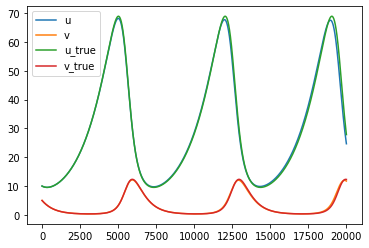

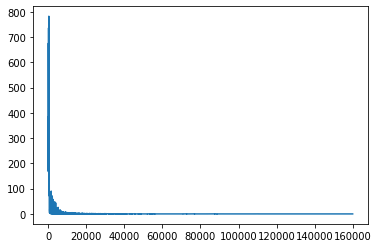

Epoch [161000/1000000] Loss:0.001517 Loss_1:0.000005 Loss_2:0.001512 Loss_3:0.000000 Lr:0.000585 Time:13.392512s (34.92min in total, 181.96min remains)
Epoch [162000/1000000] Loss:0.001456 Loss_1:0.000003 Loss_2:0.001453 Loss_3:0.000000 Lr:0.000581 Time:13.070862s (35.13min in total, 181.75min remains)
Epoch [163000/1000000] Loss:0.001635 Loss_1:0.000007 Loss_2:0.001629 Loss_3:0.000000 Lr:0.000578 Time:13.123437s (35.35min in total, 181.54min remains)
Epoch [164000/1000000] Loss:0.002631 Loss_1:0.000004 Loss_2:0.002627 Loss_3:0.000000 Lr:0.000575 Time:13.124393s (35.57min in total, 181.33min remains)
Epoch [165000/1000000] Loss:0.002728 Loss_1:0.000003 Loss_2:0.002724 Loss_3:0.000000 Lr:0.000571 Time:13.050346s (35.79min in total, 181.12min remains)
Epoch [166000/1000000] Loss:0.051255 Loss_1:0.000066 Loss_2:0.051188 Loss_3:0.000000 Lr:0.000568 Time:13.036954s (36.01min in total, 180.90min remains)
Epoch [167000/1000000] Loss:0.011355 Loss_1:0.000029 Loss_2:0.011326 Loss_3:0.000000 Lr:

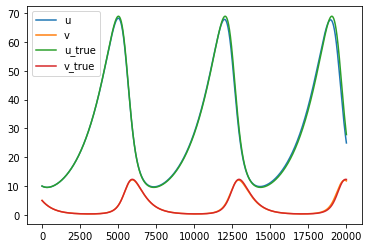

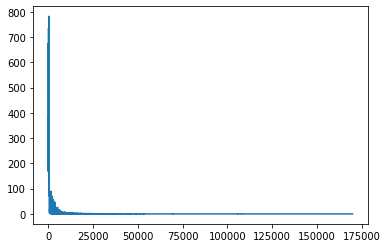

Epoch [171000/1000000] Loss:0.001482 Loss_1:0.000000 Loss_2:0.001481 Loss_3:0.000000 Lr:0.000552 Time:14.112401s (37.11min in total, 179.90min remains)
Epoch [172000/1000000] Loss:0.003544 Loss_1:0.000000 Loss_2:0.003544 Loss_3:0.000000 Lr:0.000549 Time:14.580828s (37.35min in total, 179.81min remains)
Epoch [173000/1000000] Loss:0.001711 Loss_1:0.000012 Loss_2:0.001700 Loss_3:0.000000 Lr:0.000546 Time:14.736605s (37.60min in total, 179.73min remains)
Epoch [174000/1000000] Loss:0.006878 Loss_1:0.000184 Loss_2:0.006694 Loss_3:0.000000 Lr:0.000543 Time:13.438064s (37.82min in total, 179.55min remains)
Epoch [175000/1000000] Loss:0.002735 Loss_1:0.000004 Loss_2:0.002731 Loss_3:0.000000 Lr:0.000541 Time:13.797418s (38.05min in total, 179.39min remains)
Epoch [176000/1000000] Loss:0.001405 Loss_1:0.000002 Loss_2:0.001403 Loss_3:0.000000 Lr:0.000538 Time:15.226986s (38.31min in total, 179.34min remains)
Epoch [177000/1000000] Loss:0.001749 Loss_1:0.000005 Loss_2:0.001744 Loss_3:0.000000 Lr:

KeyboardInterrupt: ignored

In [72]:
config = Config()
model = FourierModel(config).to(config.device)
model.train_model()

In [52]:
print(model.config.t)

[0.00000e+00 6.00000e-04 1.20000e-03 ... 1.19982e+01 1.19988e+01
 1.19994e+01]
